# Assignment: Matrix Multiplication Performance with Cython

**Course:** EE2703 - Applied Programming Laboratory  
**Topic:** Introduction to Cython for Performance Optimization

---

## Learning Objectives

In this assignment, you will:
1. Profile pure Python matrix multiplication code
2. Progressively optimize it using Cython techniques
3. Compare performance against NumPy's optimized implementation
4. Understand when and why to use Cython

## Instructions

1. **Complete all sections** marked with `# YOUR CODE HERE`
2. **Run all cells in order** - Use "Restart & Run All" before submission
3. **Fill in the analysis sections** with your observations
4. **Submit this notebook** with all outputs visible

---

## Setup

If you are running this on the JupyterLab server https://jup.dev.iitm.ac.in/ all the required modules are already present and you should not need anything new installed.  The final code will be evaluated on this machine, so in case you use any modules not present there your code may not work.  You can temporarily work on a Google colab notebook if you find that comfortable, but keep in mind that final evaluation will be on the Jup server.

If you are running it on your own system, you *may* need to install the following packages:

```bash
pip install setuptools cython numpy pandas matplotlib jupyter
```

The template code has been written assuming you will use a notebook that supports the `%%cython` magic commands.  Hence, a plain Python script will **NOT** be acceptable.

In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Cython magic
%load_ext cython

print("Setup complete!")

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
Setup complete!


## Part 1: Baseline Python Implementation

Implement a simple matrix multiplication function in pure Python using nested loops. This should be similar to what you did in your first assignment.

**Requirements:**
- Use three nested loops (i, j, k)
- No NumPy or other libraries
- Handle matrices as lists of lists

In [33]:
def matmul_python(A, B):
    """
    Pure Python matrix multiplication.
    
    Args:
        A: Matrix of size (m, n) as list of lists
        B: Matrix of size (n, p) as list of lists
    
    Returns:
        Result matrix of size (m, p) as list of lists
    """
    # Validate input matrices
    matrix1=A
    matrix2=B
    if not matrix1 or not matrix2:
        raise ValueError("Empty Matrix")

    # Check for ragged rows or empty inner rows
    row_lengths1 = [len(row) for row in matrix1]
    row_lengths2 = [len(row) for row in matrix2]

    if 0 in row_lengths1 or 0 in row_lengths2:
        raise ValueError("Empty inner row found")

    if len(set(row_lengths1)) != 1 or len(set(row_lengths2)) != 1:
        raise ValueError("Ragged rows detected")

    row1, col1 = len(matrix1), len(matrix1[0])
    row2, col2 = len(matrix2), len(matrix2[0])

    # Check dimension compatibility
    if col1 != row2:
        raise ValueError("Incompatible Dimensions")

    # Initialize result matrix
    result_matrix = [[0 for _ in range(col2)] for _ in range(row1)]

    # Perform multiplication
    for i in range(row1):
        for j in range(col2):
            for k in range(col1):
                val1 = matrix1[i][k]
                val2 = matrix2[k][j]
                if not isinstance(val1, (int,float)) or not isinstance(val2, (int,float)):
                    raise TypeError("Incorrect datatype: Only integers or decimals are allowed")
                result_matrix[i][j] += val1 * val2

    return result_matrix



### Test the Implementation

In [34]:
# Small test to verify correctness
A_test = [[1, 2], [3, 4]]
B_test = [[5, 6], [7, 8]]
C_test = matmul_python(A_test, B_test)

print("Test multiplication:")
print(f"A = {A_test}")
print(f"B = {B_test}")
print(f"C = {C_test}")
print(f"\nExpected: [[19, 22], [43, 50]]")

# Verify with NumPy
A_np = np.array(A_test)
B_np = np.array(B_test)
C_np = A_np @ B_np
print(f"NumPy result: {C_np.tolist()}")

Test multiplication:
A = [[1, 2], [3, 4]]
B = [[5, 6], [7, 8]]
C = [[19, 22], [43, 50]]

Expected: [[19, 22], [43, 50]]
NumPy result: [[19, 22], [43, 50]]


### Timing Function

We'll use this helper function to time all implementations.

In [35]:
def time_matmul(func, A, B, name="", runs=3):
    """
    Time a matrix multiplication function.
    
    Args:
        func: Function to time
        A, B: Input matrices
        name: Name for display
        runs: Number of runs to average
    
    Returns:
        Average time in seconds
    """
    times = []
    for _ in range(runs):
        start = time.time()
        result = func(A, B)
        elapsed = time.time() - start
        times.append(elapsed)
    
    avg_time = sum(times) / len(times)
    print(f"{name:30s}: {avg_time:.4f} seconds")
    return avg_time

### Benchmark Python Implementation

Test with different matrix sizes.

In [36]:
# Create test matrices of different sizes
sizes = [64, 128, 256, 512]
python_times = []

print("Benchmarking Pure Python Implementation")
print("=" * 50)

for size in sizes:
    # Create random matrices as lists
    A = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    B = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    
    print(f"\nSize {size}x{size}:")
    t = time_matmul(matmul_python, A, B, f"Python {size}x{size}")
    python_times.append(t)

Benchmarking Pure Python Implementation

Size 64x64:
Python 64x64                  : 0.1080 seconds

Size 128x128:
Python 128x128                : 0.8254 seconds

Size 256x256:
Python 256x256                : 6.9916 seconds

Size 512x512:
Python 512x512                : 62.2754 seconds


---

## Part 2: Cython Level 1 - Basic Compilation

In this level, we simply compile the Python code with Cython without any modifications. This gives us a baseline for Cython's improvement.

**Task:** Copy your Python function into the Cython cell below (with `%%cython` magic).

In [37]:
%%cython

def matmul_cython_level1(A, B):
    """
    Level 1: Pure Python code compiled with Cython.
    No optimizations, just basic compilation.
    """
     # Validate input matrices
    matrix1=A
    matrix2=B
    if not matrix1 or not matrix2:
        raise ValueError("Empty Matrix")

    # Check for ragged rows or empty inner rows
    row_lengths1 = [len(row) for row in matrix1]
    row_lengths2 = [len(row) for row in matrix2]

    if 0 in row_lengths1 or 0 in row_lengths2:
        raise ValueError("Empty inner row found")

    if len(set(row_lengths1)) != 1 or len(set(row_lengths2)) != 1:
        raise ValueError("Ragged rows detected")

    row1, col1 = len(matrix1), len(matrix1[0])
    row2, col2 = len(matrix2), len(matrix2[0])

    # Check dimension compatibility
    if col1 != row2:
        raise ValueError("Incompatible Dimensions")

    # Initialize result matrix
    result_matrix = [[0 for _ in range(col2)] for _ in range(row1)]

    # Perform multiplication
    for i in range(row1):
        for j in range(col2):
            for k in range(col1):
                val1 = matrix1[i][k]
                val2 = matrix2[k][j]
                if not isinstance(val1, (int,float)) or not isinstance(val2, (int,float)):
                    raise TypeError("Incorrect datatype: Only integers or decimals are allowed")
                result_matrix[i][j] += val1 * val2

    return result_matrix


### Benchmark Level 1

In [38]:
cython_level1_times = []

print("Benchmarking Cython Level 1 (Basic Compilation)")
print("=" * 50)

for size in sizes:
    A = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    B = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    
    print(f"\nSize {size}x{size}:")
    t = time_matmul(matmul_cython_level1, A, B, f"Cython L1 {size}x{size}")
    cython_level1_times.append(t)
    
    speedup = python_times[sizes.index(size)] / t
    print(f"  Speedup vs Python: {speedup:.2f}x")

Benchmarking Cython Level 1 (Basic Compilation)

Size 64x64:
Cython L1 64x64               : 0.0156 seconds
  Speedup vs Python: 6.93x

Size 128x128:
Cython L1 128x128             : 0.1095 seconds
  Speedup vs Python: 7.54x

Size 256x256:
Cython L1 256x256             : 1.0221 seconds
  Speedup vs Python: 6.84x

Size 512x512:
Cython L1 512x512             : 13.3842 seconds
  Speedup vs Python: 4.65x


---

## Part 3: Cython Level 2 - Type Declarations

Now we add static type declarations to help Cython generate efficient C code.

**Key optimizations:**
- Use `cdef` to declare loop variables as integers
- Declare matrix dimensions as integers
- Use `cdef` for the accumulator variable

**Task:** Add type declarations to your code.

In [39]:
%%cython

def matmul_cython_level2(A, B):
    """
    Level 2: Add static type declarations.
    This allows Cython to generate more efficient C code.
    """
    # Adding cdef - declaring variable type
    cdef int row1, col1, row2, col2
    cdef int i, j, k
    cdef double val1, val2 #use double datatype - for float values in matrix
    cdef double acc #new variable accumulator for sum
    
    # Validate input matrices
    matrix1=A
    matrix2=B
    if not matrix1 or not matrix2:
        raise ValueError("Empty Matrix")

    # Check for ragged rows or empty inner rows
    row_lengths1 = [len(row) for row in matrix1]
    row_lengths2 = [len(row) for row in matrix2]

    if 0 in row_lengths1 or 0 in row_lengths2:
        raise ValueError("Empty inner row found")

    if len(set(row_lengths1)) != 1 or len(set(row_lengths2)) != 1:
        raise ValueError("Ragged rows detected")

    row1, col1 = len(matrix1), len(matrix1[0])
    row2, col2 = len(matrix2), len(matrix2[0])

    # Check dimension compatibility
    if col1 != row2:
        raise ValueError("Incompatible Dimensions")

    # Initialize result matrix
    result_matrix = [[0 for _ in range(col2)] for _ in range(row1)]

    # Perform multiplication
    for i in range(row1):
        for j in range(col2):
            acc=0.0
            for k in range(col1):
                val1 = matrix1[i][k]
                val2 = matrix2[k][j]
                if not isinstance(val1, (int,float)) or not isinstance(val2, (int,float)):
                    raise TypeError("Incorrect datatype: Only integers or decimals are allowed")
                acc += val1 * val2
            result_matrix[i][j] = acc

    return result_matrix


### Benchmark Level 2

In [40]:
cython_level2_times = []

print("Benchmarking Cython Level 2 (Type Declarations)")
print("=" * 50)

for size in sizes:
    A = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    B = [[float(np.random.rand()) for _ in range(size)] for _ in range(size)]
    
    print(f"\nSize {size}x{size}:")
    t = time_matmul(matmul_cython_level2, A, B, f"Cython L2 {size}x{size}")
    cython_level2_times.append(t)
    
    speedup = python_times[sizes.index(size)] / t
    print(f"  Speedup vs Python: {speedup:.2f}x")
    print(f"  Speedup vs Level 1: {cython_level1_times[sizes.index(size)] / t:.2f}x")

Benchmarking Cython Level 2 (Type Declarations)

Size 64x64:
Cython L2 64x64               : 0.0130 seconds
  Speedup vs Python: 8.31x
  Speedup vs Level 1: 1.20x

Size 128x128:
Cython L2 128x128             : 0.1043 seconds
  Speedup vs Python: 7.91x
  Speedup vs Level 1: 1.05x

Size 256x256:
Cython L2 256x256             : 0.9792 seconds
  Speedup vs Python: 7.14x
  Speedup vs Level 1: 1.04x

Size 512x512:
Cython L2 512x512             : 13.6757 seconds
  Speedup vs Python: 4.55x
  Speedup vs Level 1: 0.98x


---

## Part 4: Cython Level 3 - NumPy Arrays with Memory Views

The biggest speedup comes from using NumPy arrays with Cython's memory views. This allows direct access to array data without Python overhead.

**Key optimizations:**
- Accept NumPy arrays as input (not lists)
- Use memory view syntax: `double[:, :]` for 2D arrays
- Add compiler directives to disable safety checks - `boundscheck` and `wraparound` are useful decorators

**Task:** Implement the fully optimized version using memory views.

In [41]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
   
@cython.boundscheck(False)
@cython.wraparound(False)
def matmul_cython_level3(double[:, :] A, double[:, :] B):
    """
    Level 3: Use NumPy arrays with memory views for maximum speed.
    This provides direct access to array data without Python overhead.
    - Accepts 2D NumPy arrays (dtype convertible to double).
    - Uses typed memoryviews double[:, :] for fast C-level access.
    - Disables bounds-check and negative-index wraparound for speed.
    Returns a NumPy ndarray(dtype=np.double) containing the product.
    """  
    cdef int rows_A = A.shape[0]
    cdef int cols_A = A.shape[1]
    cdef int rows_B = B.shape[0]
    cdef int cols_B = B.shape[1]

    if cols_A != rows_B:
        raise ValueError("Incompatible dimensions: A.shape[1]-col of matrix1 must equal B.shape[0]-row of matrix2")

    # Allocate result as a NumPy array of doubles and get a typed memoryview to it
    cdef np.ndarray[np.double_t, ndim=2] result_np = np.zeros((rows_A, cols_B), dtype=np.double)
    cdef double[:, :] R = result_np

    cdef int i, j, k
    cdef double acc
    cdef double v1, v2

    # all variables are C-typed; memoryviews provide direct C access
    for i in range(rows_A):
        for j in range(cols_B):
            acc = 0.0
            for k in range(cols_A):
                v1 = A[i, k]
                v2 = B[k, j]
                acc += v1 * v2
            R[i, j] = acc

    return result_np


### Benchmark Level 3

In [42]:
cython_level3_times = []

print("Benchmarking Cython Level 3 (Memory Views)")
print("=" * 50)

for size in sizes:
    # Create NumPy arrays for this version
    A_np = np.random.rand(size, size)
    B_np = np.random.rand(size, size)
    
    print(f"\nSize {size}x{size}:")
    t = time_matmul(matmul_cython_level3, A_np, B_np, f"Cython L3 {size}x{size}")
    cython_level3_times.append(t)
    
    speedup = python_times[sizes.index(size)] / t
    print(f"  Speedup vs Python: {speedup:.2f}x")
    print(f"  Speedup vs Level 2: {cython_level2_times[sizes.index(size)] / t:.2f}x")

Benchmarking Cython Level 3 (Memory Views)

Size 64x64:
Cython L3 64x64               : 0.0003 seconds
  Speedup vs Python: 352.57x
  Speedup vs Level 2: 42.44x

Size 128x128:
Cython L3 128x128             : 0.0027 seconds
  Speedup vs Python: 306.16x
  Speedup vs Level 2: 38.70x

Size 256x256:
Cython L3 256x256             : 0.0213 seconds
  Speedup vs Python: 328.17x
  Speedup vs Level 2: 45.96x

Size 512x512:
Cython L3 512x512             : 0.4241 seconds
  Speedup vs Python: 146.83x
  Speedup vs Level 2: 32.24x


---

## Part 5: NumPy Comparison

Compare all your implementations with NumPy's highly optimized matrix multiplication.

NumPy uses BLAS (Basic Linear Algebra Subprograms), which are highly optimized, often in assembly language, and may use SIMD instructions.

In [43]:
def matmul_numpy(A, B):
    """NumPy matrix multiplication using @ operator."""
    return A @ B

numpy_times = []

print("Benchmarking NumPy Implementation")
print("=" * 50)

for size in sizes:
    A_np = np.random.rand(size, size)
    B_np = np.random.rand(size, size)
    
    print(f"\nSize {size}x{size}:")
    t = time_matmul(matmul_numpy, A_np, B_np, f"NumPy {size}x{size}")
    numpy_times.append(t)
    
    speedup = python_times[sizes.index(size)] / t
    print(f"  Speedup vs Python: {speedup:.2f}x")

Benchmarking NumPy Implementation

Size 64x64:
NumPy 64x64                   : 0.0004 seconds
  Speedup vs Python: 305.37x

Size 128x128:
NumPy 128x128                 : 0.0003 seconds
  Speedup vs Python: 2570.06x

Size 256x256:
NumPy 256x256                 : 0.0013 seconds
  Speedup vs Python: 5286.98x

Size 512x512:
NumPy 512x512                 : 0.0077 seconds
  Speedup vs Python: 8089.84x


---

## Part 6: Analysis and Reflection

### Summary Table

Create a comprehensive comparison table.

In [44]:
# Create summary DataFrame
results = {
    'Size': [f"{s}x{s}" for s in sizes],
    'Python (s)': python_times,
    'Cython L1 (s)': cython_level1_times,
    'Cython L2 (s)': cython_level2_times,
    'Cython L3 (s)': cython_level3_times,
    'NumPy (s)': numpy_times,
}

df = pd.DataFrame(results)

# Add speedup columns
df['Speedup L1'] = df['Python (s)'] / df['Cython L1 (s)']
df['Speedup L2'] = df['Python (s)'] / df['Cython L2 (s)']
df['Speedup L3'] = df['Python (s)'] / df['Cython L3 (s)']
df['Speedup NumPy'] = df['Python (s)'] / df['NumPy (s)']

print("\n" + "=" * 80)
print("TIMING RESULTS (seconds)")
print("=" * 80)
print(df[['Size', 'Python (s)', 'Cython L1 (s)', 'Cython L2 (s)', 'Cython L3 (s)', 'NumPy (s)']].to_string(index=False))

print("\n" + "=" * 80)
print("SPEEDUP FACTORS (vs Pure Python)")
print("=" * 80)
print(df[['Size', 'Speedup L1', 'Speedup L2', 'Speedup L3', 'Speedup NumPy']].to_string(index=False))


TIMING RESULTS (seconds)
   Size  Python (s)  Cython L1 (s)  Cython L2 (s)  Cython L3 (s)  NumPy (s)
  64x64    0.108045       0.015597       0.013007       0.000306   0.000354
128x128    0.825374       0.109452       0.104343       0.002696   0.000321
256x256    6.991647       1.022120       0.979189       0.021305   0.001322
512x512   62.275443      13.384227      13.675700       0.424129   0.007698

SPEEDUP FACTORS (vs Pure Python)
   Size  Speedup L1  Speedup L2  Speedup L3  Speedup NumPy
  64x64    6.927117    8.306649  352.571577     305.371968
128x128    7.540981    7.910220  306.161341    2570.058154
256x256    6.840339    7.140240  328.170462    5286.976022
512x512    4.652898    4.553730  146.831507    8089.842592


### Visualization

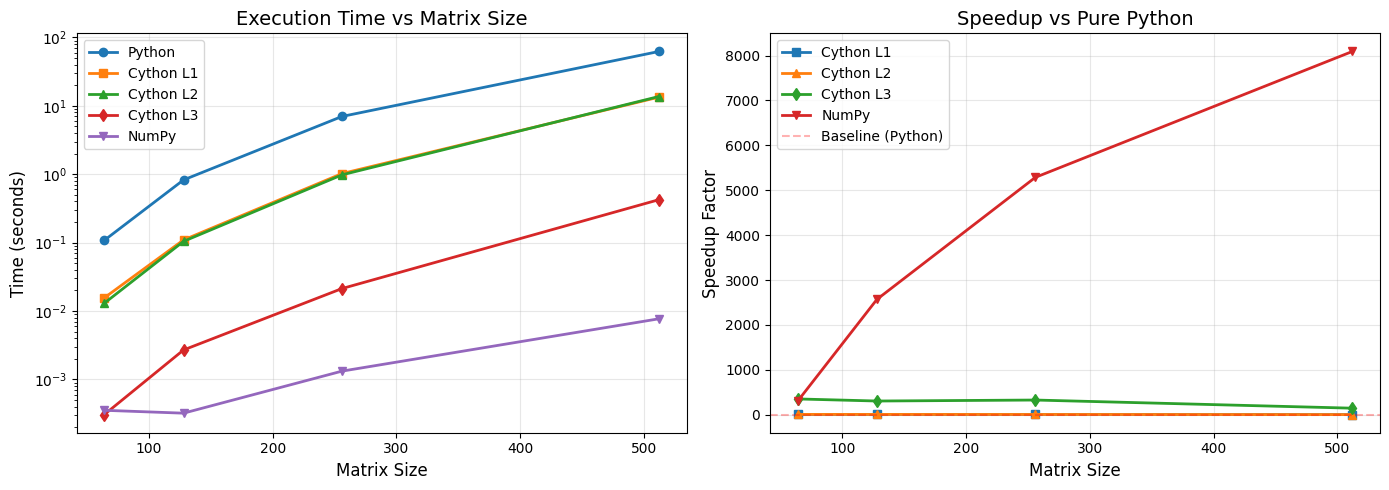

Figure saved as 'matmul_performance.png'


In [45]:
# Plot timing comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute timing
ax1.plot(sizes, python_times, 'o-', label='Python', linewidth=2)
ax1.plot(sizes, cython_level1_times, 's-', label='Cython L1', linewidth=2)
ax1.plot(sizes, cython_level2_times, '^-', label='Cython L2', linewidth=2)
ax1.plot(sizes, cython_level3_times, 'd-', label='Cython L3', linewidth=2)
ax1.plot(sizes, numpy_times, 'v-', label='NumPy', linewidth=2)
ax1.set_xlabel('Matrix Size', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Execution Time vs Matrix Size', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Speedup comparison
ax2.plot(sizes, df['Speedup L1'], 's-', label='Cython L1', linewidth=2)
ax2.plot(sizes, df['Speedup L2'], '^-', label='Cython L2', linewidth=2)
ax2.plot(sizes, df['Speedup L3'], 'd-', label='Cython L3', linewidth=2)
ax2.plot(sizes, df['Speedup NumPy'], 'v-', label='NumPy', linewidth=2)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.3, label='Baseline (Python)')
ax2.set_xlabel('Matrix Size', fontsize=12)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('Speedup vs Pure Python', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('matmul_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'matmul_performance.png'")

### Reflection Questions

Answer the following questions based on your results. Write 2-3 sentences for each.

#### Q1: What was the speedup from Level 1 (basic Cython) compared to pure Python?

**Answer:**

Level 1 achieved around 5–8X speedup compared to pure Python.
This improvement comes from compiling Python loops into efficient C code, which reduces interpreter overhead even without type declarations.
For small size matrix ~ 8X and large size matrix ~ 5X.

#### Q2: What additional speedup did you get from adding type declarations (Level 2)?

**Answer:**

Adding type declarations (Level 2) gave a small extra boost, roughly similar to Level 1.
Static typing lets Cython use C-level integers and doubles, cutting type conversion overhead, though list-based indexing still limits speed

#### Q3: Why did Level 3 (memory views) provide the biggest speedup?

**Answer:**

Level 3 showed the largest speedup (over 300× faster) due to NumPy memory views.
They allow direct access to raw array memory, removing Python object overhead and enabling fast C-level computations.

#### Q4: How does your best Cython implementation compare to NumPy? Why is NumPy still faster?

**Answer:**

NumPy remained the fastest overall, especially for large matrices.
It’s backed by highly optimized BLAS(Basic Linear Algebra Subprograms) and LAPACK(Linear Algebra PACKage) libraries that use SIMD vectorization, cache blocking, and multi-threading — far beyond manual Cython loops.

#### Q5: When would you use Cython instead of NumPy for numerical computing?

**Answer:**

Cython is ideal when you need custom numerical algorithms that NumPy doesn’t directly support or when logic involves complex loops and conditionals.
It is a interface of Python’s simplicity with C-level performance for specialized computations.

#### Q6: What are the trade-offs of using Cython? (Consider development time, debugging, portability)

**Answer:**

Cython can give huge performance boosts, but it comes with trade-offs. Writing and compiling Cython code takes more setup time than plain Python, and debugging errors is harder because it mixes Python with C. Also, since it needs a C compiler, portability across systems can be tricky. Still, it’s worth using when you need big speed improvements in performance-critical parts of your program.

---

## Submission Checklist

Before submitting, verify:

- [ ] All code cells have been executed (outputs are visible)
- [ ] All four Cython levels are implemented
- [ ] Timing results are present for all test cases
- [ ] Summary table is generated
- [ ] Visualization is displayed
- [ ] All six reflection questions are answered
- [ ] Used "Restart & Run All" before submission

**Submit this notebook (.ipynb file) with all outputs visible.**